# Bias-variance tradeoff 

In [1]:
import numpy as np
import pandas as pd

from pandas import Series
from pandas import DataFrame

from sklearn.linear_model import LogisticRegression
from plotnine import *

# Local imports
from common import *
from convenience import *

## I. Train two classifiers on relatively large dataset 

We consider here a relatively simple prediction task with a relatively small feature set and an impossible prediction task with the same feature set for comparison.

In [2]:
sampler_0 = lambda n: data_sampler(n, 8, lambda x: logit(x, Series([0, 0])))
sampler_1 = lambda n: data_sampler(n, 8, lambda x: logit(x, Series([10, 10])))

Again use majority voting and logistic regression as classifiers to compare

In [3]:
train = sampler_0(100)
features = list(train.columns.values[:-1])
clf_1 = MajorityVoting(features)
clf_1.fit(train, train['y'])
clf_2 = LogisticRegression(solver = 'lbfgs')
clf_2.fit(train[features], train['y'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

Simple test run to see that all functions are correctly defined

In [4]:
print('MV training error: {:.2f}%'.format(empirical_risk(clf_1, train[features], train['y'])))
print('LR training error: {:.2f}%'.format(empirical_risk(clf_2, train[features], train['y'])))

MV training error: 4.00%
LR training error: 31.00%


## II. Measuring training and test error on different dataset sizes

### Configuration and template for data collection for an impossible task

In [5]:
k = 100
sizes = [5, 25, 125, 625]

result = (combine_categories({'size': sizes, 'method': ['MV', 'LR'], 'type': ['training', 'test'], 'experiment': list(range(k))})
         .assign(error = np.nan)
         .set_index(['size', 'method', 'type', 'experiment'])
         .sort_index())
head(result)

error
size method type experiment       
5    LR     test 0             NaN
                 1             NaN
                 2             NaN
                 3             NaN
                 4             NaN

### Experiment

In [6]:
from tqdm import tnrange, tqdm_notebook

features = list(sampler_0(1).columns.values[:-1])
for size in sizes:
    for experiment in tnrange(k, desc = 'Size: {:_>4}'.format(size)):
        
        train = sampler_0(size)
        test = sampler_0(size)
        clf_1.fit(train[features], train['y'])
        result.loc[(size, 'MV', 'training', experiment), 'error'] = empirical_risk(clf_1, train[features], train['y'])
        result.loc[(size, 'MV', 'test',  experiment), 'error'] = empirical_risk(clf_1, test[features], test['y'])

        try:
            clf_2.fit(train[features], train['y'])
        except:
            continue

        result.loc[(size, 'LR', 'training', experiment), 'error'] = empirical_risk(clf_2, train[features], train['y'])
        result.loc[(size, 'LR', 'test', experiment), 'error'] = empirical_risk(clf_2, test[features], test['y'])
        
        
tail(result.sort_index().unstack(['method', 'type'])) 

error                         
method              LR              MV         
type              test training   test training
size experiment                                
625  95          51.04    46.08  47.84    25.92
     96          52.64    46.40  49.12    25.12
     97          52.96    45.60  50.24    27.36
     98          48.48    44.00  51.68    25.60
     99          50.40    48.64  48.00    25.12

### Visualisation of training and test errors

In [7]:
from pandas.api.types import CategoricalDtype
SizeType = CategoricalDtype(sizes, ordered = True)
TypeType = CategoricalDtype(['training', 'test'], ordered = True)
df = (result.reset_index()
      .assign(size = lambda df: df['size'].astype(SizeType))
      .assign(type = lambda df: df['type'].astype(TypeType))
      .pipe(lambda df: df.loc[~df['error'].isna(), :])
      .assign(risk = 50))
    
df.to_csv('results/training_bias.csv', index = False)
head(df)

,size,method,type,experiment,error,risk
0,5,LR,test,0,60.0,50
1,5,LR,test,1,20.0,50
2,5,LR,test,2,20.0,50
3,5,LR,test,3,0.0,50
5,5,LR,test,5,0.0,50


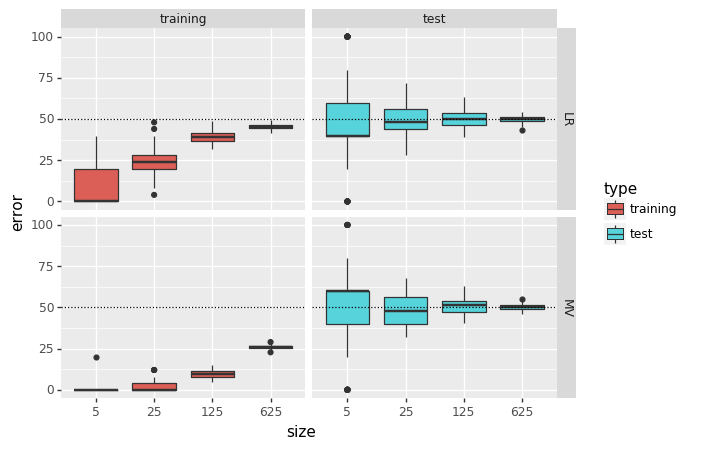

<ggplot: (-9223372029314229686)>

In [8]:
p = ggplot(data = df)
p = p + geom_boxplot(aes(x ='size', y = 'error', fill = 'type'))
p = p + geom_hline(aes(yintercept ='risk'), linetype = ':')
p = p + facet_grid(['method', 'type']) 
p.save('training_bias_1.pdf', path='results', height=6, width=12, verbose=False)
display(p)




### Visualising optimism

Lets choose experiments where test and training error is present and compute the difference between training and test errors: $$\Delta = error_{test}-error_{train}$$


In [9]:
df = (result.unstack('type').reset_index()
      .assign(size = lambda df: df['size'].astype(SizeType))
      .assign(optimism = lambda df: df[('error','test')] - df[('error','training')])
      .pipe(lambda df: df.loc[~df['optimism'].isna(), ['size', 'method', 'experiment','optimism']]))

df = df.groupby(['size', 'method']).apply(
        lambda df: df.assign(mean_optimism = lambda df:df['optimism'].mean()))

df.columns = df.columns.droplevel(1)
head(df)

,size,method,experiment,optimism,mean_optimism
0,5,LR,0,40.0,39.583333
1,5,LR,1,20.0,39.583333
2,5,LR,2,20.0,39.583333
3,5,LR,3,-20.0,39.583333
5,5,LR,5,0.0,39.583333


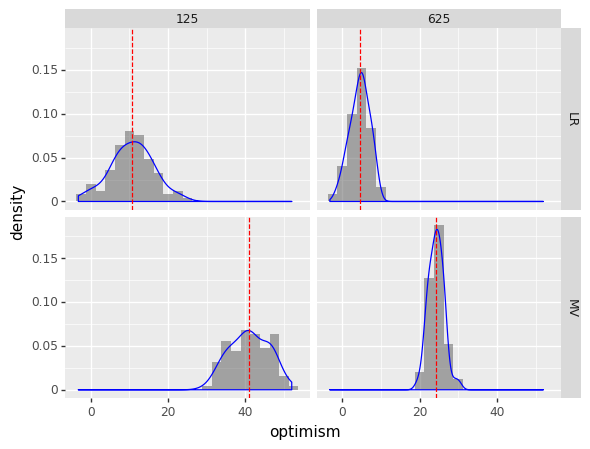

<ggplot: (7541133860)>

In [10]:
p = ggplot(df.loc[df['size'].isin([125, 625]),:])
p = p + geom_histogram(aes(x = 'optimism', y = '..density..'), binwidth=2.5, alpha=0.5)
p = p + geom_density(aes(x = 'optimism'), color="blue")
p = p + geom_vline(aes(xintercept = 'mean_optimism'), color = 'red', linetype = '--')
p = p + facet_grid(['method', 'size'])
p.save('training_bias_2.pdf', path='results', height=6, width=12, verbose=False)
display(p)

### Visualising correlation between training error and optimism

In [12]:
df = (result.unstack('type').reset_index()
      .assign(size = lambda df: df['size'].astype(SizeType))
      .assign(optimism = lambda df: df[('error','test')] - df[('error','training')])
      .assign(training = lambda df: df[('error','training')])
      .pipe(lambda df: df.loc[~df['optimism'].isna(), ['size', 'method', 'experiment', 'training', 'optimism']]))

df = df.groupby(['size', 'method']).apply(
        lambda df: df.assign(mean_optimism = lambda df:df['optimism'].mean()))

df = df.groupby(['size', 'method']).apply(
        lambda df: df.assign(mean_training = lambda df:df['training'].mean()))

df = df.groupby(['size', 'method']).apply(
        lambda df: df.assign(cor_training = lambda df:df['training'] + df['mean_optimism']))

df.columns = df.columns.droplevel(1)
head(df)

,size,method,experiment,optimism,training,mean_optimism,mean_training,cor_training
0,5,LR,0,40.0,20.0,39.583333,10.0,59.583333
1,5,LR,1,20.0,0.0,39.583333,10.0,39.583333
2,5,LR,2,20.0,0.0,39.583333,10.0,39.583333
3,5,LR,3,-20.0,20.0,39.583333,10.0,59.583333
5,5,LR,5,0.0,0.0,39.583333,10.0,39.583333


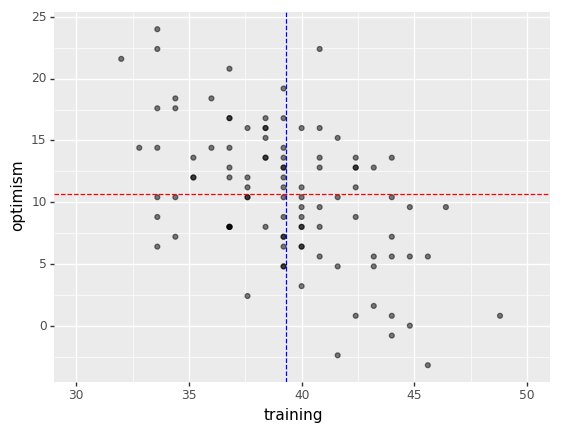

<ggplot: (7541517846)>

In [13]:
p = ggplot(df.loc[(df['size'] == 125) & (df['method'] == 'LR'),:])
p = p + geom_point(aes(x='training', y='optimism'), alpha=0.5)
p = p + geom_hline(aes(yintercept = 'mean_optimism'), color = 'red', linetype = '--')
p = p + geom_vline(aes(xintercept = 'mean_training'), color = 'blue', linetype = '--')
p = p + xlim(30,50)
p.save('training_bias_3.pdf', path='results', height=6, width=12, verbose=False)
display(p)

## III. Measuring training and test error when the amount of data fixed

Normally, you have fixed budget of data samples that you have to split into test and training sets by yourselt. 
There are tradeoffs:

* Too big training set makes the test error estimate unreliable
* Too small training set makes it hard to train the model

### Configuration and template for data collection for an impossible task

In [185]:
k = 100
size = 125
training_sizes = list(range(10, size, 10))
features = list(sampler_0(1).columns.values[:-1])


result = (combine_categories({'training_size': training_sizes, 'method': ['MV', 'LR'], 'type': ['training', 'test'], 'experiment': list(range(k))})
         .assign(size = size, error = np.nan)
         .set_index(['size', 'method', 'training_size', 'type', 'experiment'])
         .sort_index())
head(result)

error
size method training_size type experiment       
125  LR     10            test 0             NaN
                               1             NaN
                               2             NaN
                               3             NaN
                               4             NaN

### Experiment

In [186]:
from tqdm import tqdm

for training_size in tqdm_notebook(training_sizes, desc = 'Holdout sizes'):
    
    for experiment in range(k):
    
        data = sampler_0(size)
        train = data.iloc[:training_size]
        test = data.iloc[training_size:]
    
        clf_1.fit(train[features], train['y'])    
        result.loc[(size, 'MV', training_size, 'training', experiment), 'error'] = empirical_risk(clf_1, train[features], train['y'])
        result.loc[(size, 'MV', training_size, 'test', experiment), 'error'] = empirical_risk(clf_1, test[features], test['y'])
    
        try:
            clf_2.fit(train[features], train['y'])
        except:
            continue
        
        result.loc[(size, 'LR', training_size, 'training', experiment), 'error'] = empirical_risk(clf_2, train[features], train['y'])
        result.loc[(size, 'LR', training_size, 'test', experiment), 'error'] = empirical_risk(clf_2, test[features], test['y'])
    
head(result.unstack('type'))  


error         
type                                       test training
size method training_size experiment                    
125  LR     10            0           54.782609     10.0
                          1           41.739130      0.0
                          2           44.347826     20.0
                          3           53.043478     10.0
                          4           54.782609     20.0

### Visualisation

In [187]:
TrSizeType = CategoricalDtype(categories=training_sizes, ordered=True)
MethodType = CategoricalDtype(categories=['LR', 'MV'], ordered=True)

df = (result.reset_index()
      .assign(training_size = lambda df: df['training_size'].astype(TrSizeType))
      .assign(type = lambda df: df['type'].astype(TypeType))
      .assign(method = lambda df: df['method'].astype(MethodType))
     )

sdf = (df.groupby(['size', 'method', 'training_size', 'type'])
       .mean()[['error']]
       .reset_index())

/anaconda3/envs/machine-learning/lib/python3.6/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/anaconda3/envs/machine-learning/lib/python3.6/site-packages/plotnine/layer.py:360: UserWarning: stat_ydensity : Removed 2 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
/anaconda3/envs/machine-learning/lib/python3.6/site-packages/statsmodels/sandbox/nonparametric/kernels.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  w = 1. / (h * n) * np.sum(self((xs-x)/h), axis=0)
/anaconda3/envs/machine-learning/lib/python3.6/site-packages/statsmodels/sandbox/nonparametric/kernels.py:204: RuntimeWarning: divide by zero encountered in true_divide
  w = 1. / (h * n) * np.sum(self((xs-x)/h), axis=0)
/anaconda3/envs/machine-learning/lib/python3.6/site-packages/statsmodels/sandbox/nonparametric/kernels.py:204: RuntimeWarning: in

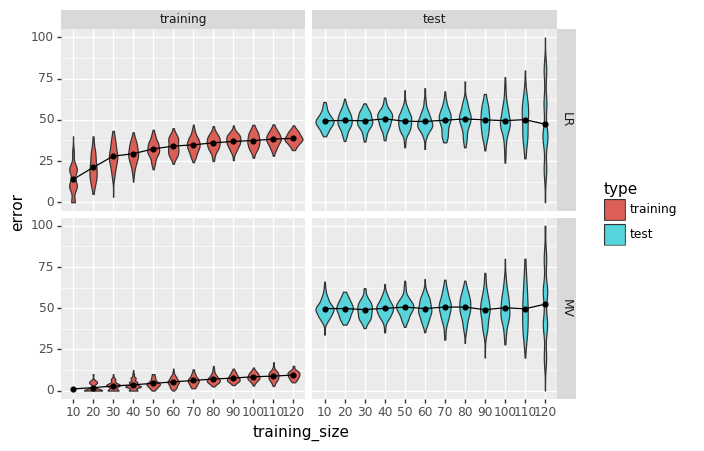

<ggplot: (-9223372029292794101)>

In [188]:
p = ggplot(data = df) 
p = p + geom_violin(aes(x = 'training_size', y = 'error', fill='type'))
p = p + geom_point(aes(x = 'training_size', y = 'error'), data = sdf)
p = p + geom_line(aes(x = 'training_size', y = 'error'), group = 1, data = sdf)
p = p + facet_grid(['method', 'type'])
p.save('bias_variance_dilemma_0.pdf', path='results', height=6, width=12, verbose=False)
display(p)

### Same experiment with different dataset 

error         
type                                       test training
size method training_size experiment                    
125  LR     10            0           26.086957      0.0
                          1           45.217391     20.0
                          2           32.173913      0.0
                          3           46.956522      0.0
                          4           39.130435      0.0

/anaconda3/envs/machine-learning/lib/python3.6/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or
/anaconda3/envs/machine-learning/lib/python3.6/site-packages/statsmodels/sandbox/nonparametric/kernels.py:204: RuntimeWarning: divide by zero encountered in double_scalars
  w = 1. / (h * n) * np.sum(self((xs-x)/h), axis=0)
/anaconda3/envs/machine-learning/lib/python3.6/site-packages/statsmodels/sandbox/nonparametric/kernels.py:204: RuntimeWarning: divide by zero encountered in true_divide
  w = 1. / (h * n) * np.sum(self((xs-x)/h), axis=0)
/anaconda3/envs/machine-learning/lib/python3.6/site-packages/statsmodels/sandbox/nonparametric/kernels.py:204: RuntimeWarning: invalid value encountered in true_divide
  w = 1. / (h * n) * np.sum(self((xs-x)/h), axis=0)
/anaconda3/envs/machine-learning/lib/python3.6/site-packages/statsmodels/sandbox/nonparametric/kernels.py:204: RuntimeWarn

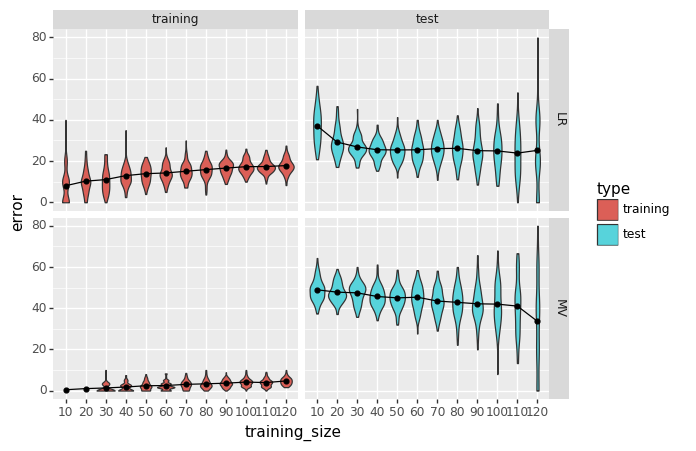

<ggplot: (-9223372029308699227)>

In [189]:
result.loc[:, 'error'] = np.nan

for training_size in tqdm_notebook(training_sizes, desc = 'Holdout sizes'):
    
    for experiment in range(k):
    
        data = sampler_1(size)
        train = data.iloc[:training_size]
        test = data.iloc[training_size:]
    
        clf_1.fit(train[features], train['y'])    
        result.loc[(size, 'MV', training_size, 'training', experiment), 'error'] = empirical_risk(clf_1, train[features], train['y'])
        result.loc[(size, 'MV', training_size, 'test', experiment), 'error'] = empirical_risk(clf_1, test[features], test['y'])
    
        try:
            clf_2.fit(train[features], train['y'])
        except:
            continue
        
        result.loc[(size, 'LR', training_size, 'training', experiment), 'error'] = empirical_risk(clf_2, train[features], train['y'])
        result.loc[(size, 'LR', training_size, 'test', experiment), 'error'] = empirical_risk(clf_2, test[features], test['y'])
    
display(head(result.unstack('type')))

df = (result.reset_index()
      .assign(training_size = lambda df: df['training_size'].astype(TrSizeType))
      .assign(type = lambda df: df['type'].astype(TypeType))
      .assign(method = lambda df: df['method'].astype(MethodType))
     )

sdf = (df.groupby(['size', 'method', 'training_size', 'type'])
       .mean()[['error']]
       .reset_index())

p = ggplot(data = df) 
p = p + geom_violin(aes(x = 'training_size', y = 'error', fill='type'))
p = p + geom_point(aes(x = 'training_size', y = 'error'), data = sdf)
p = p + geom_line(aes(x = 'training_size', y = 'error'), group = 1, data = sdf)
p = p + facet_grid(['method', 'type'])
p.save('bias_variance_dilemma_1.pdf', path='results', height=6, width=12, verbose=False)
display(p)

In [42]:
%config IPCompleter.greedy=True